In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load the datasets
# Ensure the CSV files are in the same directory as this notebook
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Data Loaded Successfully!")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Data Loaded Successfully!
Train shape: (421570, 5)
Test shape: (115064, 4)


In [4]:
# Merge Stores data
train_merged = train.merge(stores, on='Store', how='left')
test_merged = test.merge(stores, on='Store', how='left')

# Merge Features data
# Note: We perform a left join to ensure we keep all rows from our train/test sets
train_final = train_merged.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_final = test_merged.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

print("Merging Complete.")
display(train_final.head())

Merging Complete.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [5]:
# 1. Handle Missing Values
# Fill MarkDown NaNs with 0 (assuming NaN means no markdown active)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_final[markdown_cols] = train_final[markdown_cols].fillna(0)
test_final[markdown_cols] = test_final[markdown_cols].fillna(0)

# Fill CPI and Unemployment with the mean (simple imputation) or ffill
train_final['CPI'] = train_final['CPI'].fillna(train_final['CPI'].mean())
train_final['Unemployment'] = train_final['Unemployment'].fillna(train_final['Unemployment'].mean())
test_final['CPI'] = test_final['CPI'].fillna(test_final['CPI'].mean())
test_final['Unemployment'] = test_final['Unemployment'].fillna(test_final['Unemployment'].mean())

In [6]:
#2. Convert Date to Datetime
train_final['Date'] = pd.to_datetime(train_final['Date'])
test_final['Date'] = pd.to_datetime(test_final['Date'])

# 3. Encode 'IsHoliday' (Boolean to Int)
train_final['IsHoliday'] = train_final['IsHoliday'].astype(int)
test_final['IsHoliday'] = test_final['IsHoliday'].astype(int)

# 4. Encode 'Type' (A, B, C to 1, 2, 3)
type_mapping = {'A': 1, 'B': 2, 'C': 3}
train_final['Type'] = train_final['Type'].map(type_mapping)
test_final['Type'] = test_final['Type'].map(type_mapping)

print("Missing values handled and types encoded.")


Missing values handled and types encoded.


In [7]:
def extract_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    return df

train_final = extract_date_features(train_final)
test_final = extract_date_features(test_final)

# Drop the original 'Date' column as models can't process datetime objects directly
train_final_clean = train_final.drop(['Date'], axis=1)
test_final_clean = test_final.drop(['Date'], axis=1)

display(train_final_clean.head())

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week
0,1,1,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
1,1,1,46039.49,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,6
2,1,1,41595.55,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,7
3,1,1,19403.54,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,8
4,1,1,21827.90,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,9


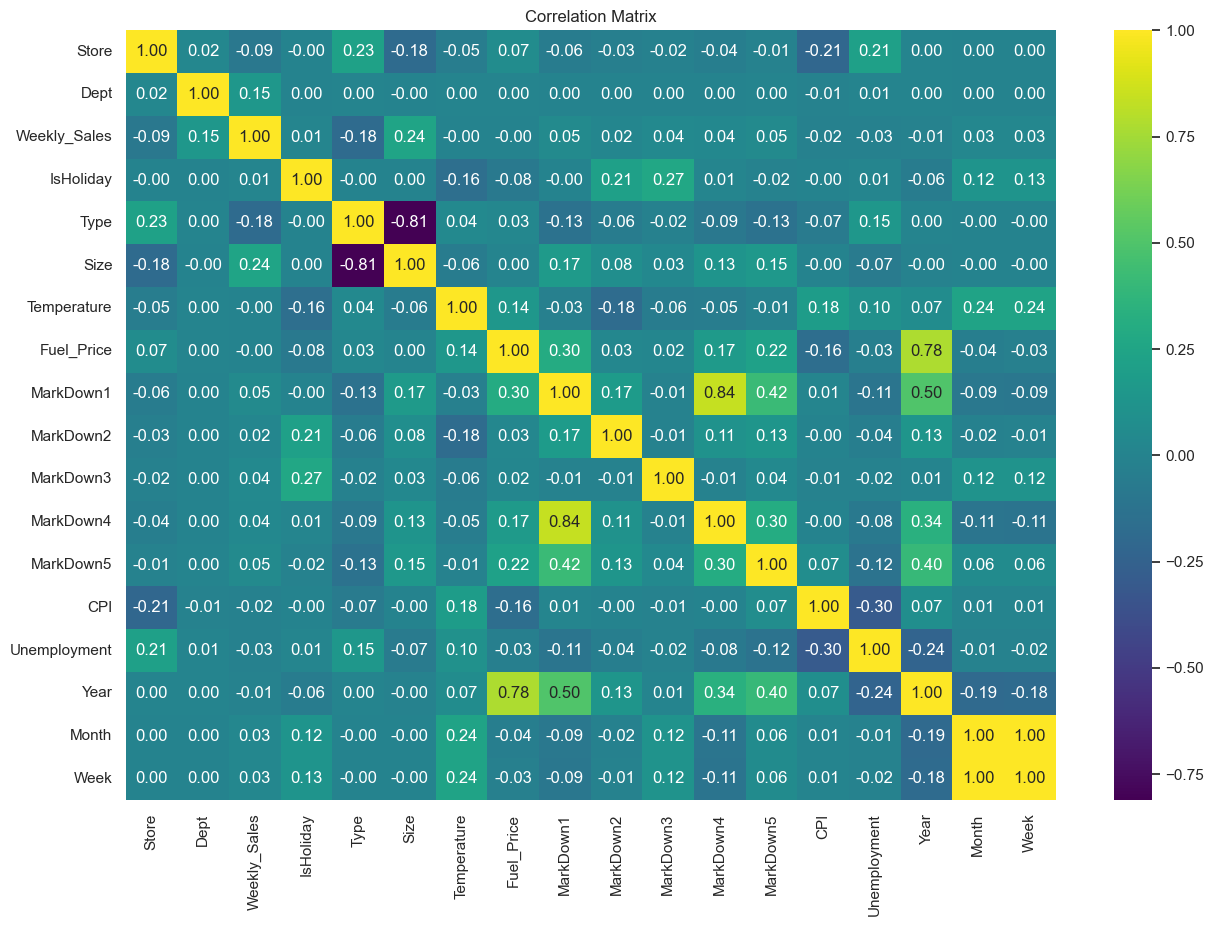

In [9]:
# Correlation Matrix
plt.figure(figsize=(15, 10))
sns.heatmap(train_final_clean.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

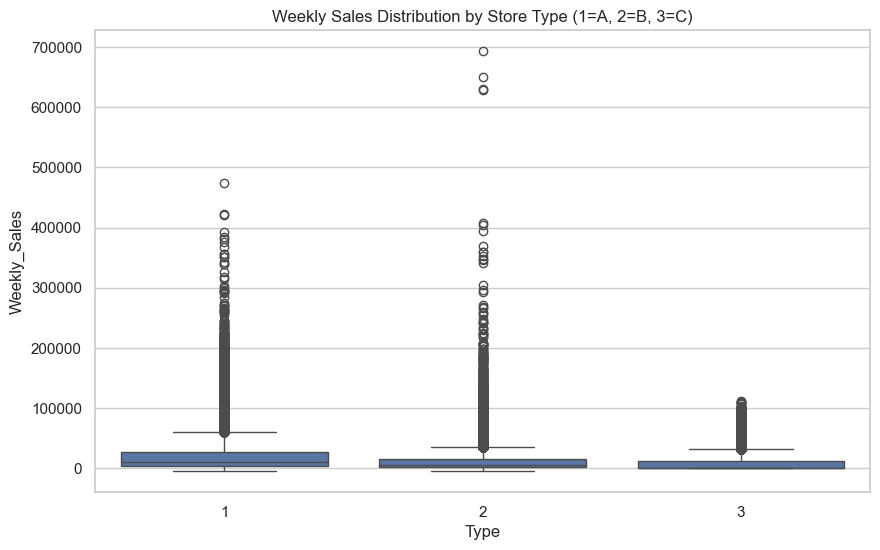

In [ ]:
# Weekly Sales by Store Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Weekly_Sales', data=train_final)
plt.title('Weekly Sales Distribution by Store Type (1=A, 2=B, 3=C)')
plt.show()

In [ ]:
# Define Features (X) and Target (y)
X = train_final_clean.drop(['Weekly_Sales'], axis=1)
y = train_final_clean['Weekly_Sales']

In [ ]:
# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the model
# n_estimators=50 for speed, increase to 100+ for better accuracy
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, n_jobs=-1, random_state=42)

In [ ]:
print("Training Model... (this may take a minute)")
rf_model.fit(X_train, y_train)
print("Training Complete.")

Training Model... (this may take a minute)
Training Complete.


In [ ]:
# Predict on validation set
y_pred = rf_model.predict(X_val)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

Root Mean Squared Error (RMSE): 3776.78
R-squared Score: 0.9726


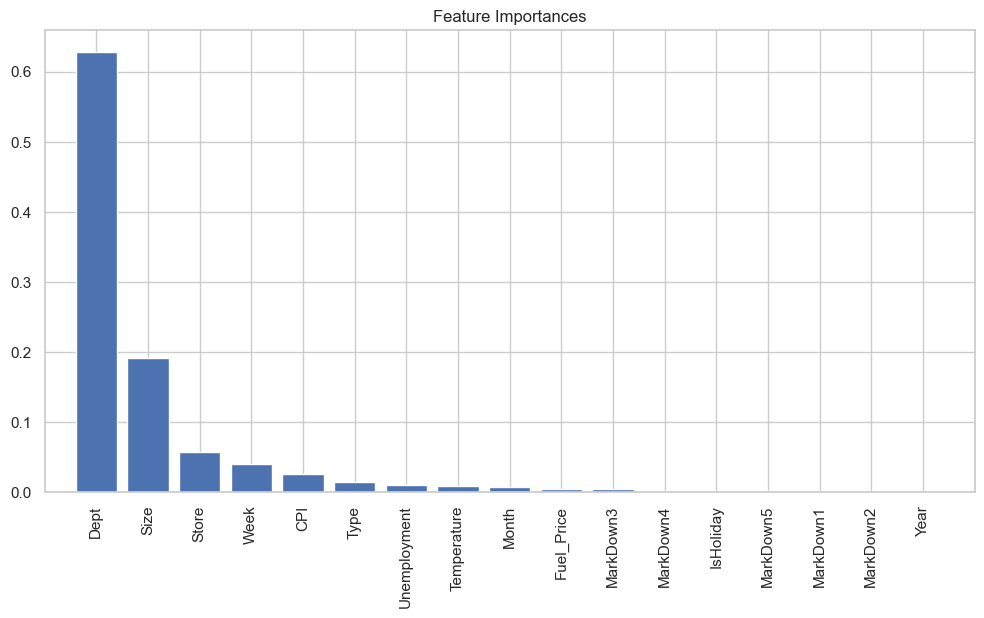

In [ ]:
# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features_list[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
test_pred = rf_model.predict(test_final_clean)

# Create submission DataFrame
submission = pd.DataFrame({
    'Store': test_final['Store'],
    'Dept': test_final['Dept'],
    'Date': test_final['Date'],
    'Weekly_Sales_Pred': test_pred
})

print("First 5 Predictions:")
display(submission.head())

First 5 Predictions:


,Store,Dept,Date,Weekly_Sales_Pred
0,1,1,2012-11-02,29271.347919
1,1,1,2012-11-09,18808.880317
2,1,1,2012-11-16,18944.997125
3,1,1,2012-11-23,19535.607950
4,1,1,2012-11-30,19827.158995
